## Cost estimation

We want an estimate for how much the faithfulness experiment might cost if we're running it with OpenAI.
Using the current pricing, calculating the token count of the examples in the dataset and setting an upper bound on the output tokens we gain an estimate for running this experiment with the different OAI models, yielding the below:
<br><br>
|model                   | price    |
|:-----------------------|:---------|
| chatgpt-4o-latest      | $166.48  |
| gpt-4-turbo            | $335.74  |
| gpt-4-turbo-2024-04-09 | $335.74  |
| gpt-4                  | $1005.84 |
| gpt-4-32k              | $2011.69 |

In [79]:
import psycopg2
import boto3
import json
import pandas as pd
import tiktoken
import sys
import jinja2
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

sys.path.append(Path(".").absolute().parent.as_posix())

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
session = boto3.Session()
ssm = session.client('ssm')
response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)
secret = response['Parameter']['Value']

In [4]:
conn = psycopg2.connect(**json.loads(secret))

In [5]:
cur = conn.cursor()

cur.execute("""
    SELECT DISTINCT * 
    FROM qapair 
    WHERE pipeline_id = 'g_eval_comparison_experiment_2';
""")

rows = cur.fetchall()

len(rows)

15403

In [6]:
df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

### Pricing data:

 |Model |Input |Output |
 |---|---|---|
 chatgpt-4o-latest |$5.00 / 1M tokens |$15.00 / 1M tokens |
 gpt-4-turbo |$10.00 / 1M tokens |$30.00 / 1M tokens |
 gpt-4-turbo-2024-04-09 |$10.00 / 1M tokens |$30.00 / 1M tokens |
 gpt-4 |$30.00 / 1M tokens |$60.00 / 1M tokens |
 gpt-4-32k |$60.00 / 1M tokens |$120.00 / 1M tokens

 Source: https://openai.com/api/pricing/

 All we need to do now is estimate the number of tokens this task is going to take on input & output.<br><br>

 Base assumptions:
 - output tokens are counted as 3 per eval (this is an upper bound accounting for malformatted cases)
 - the token count of the input is `prompt + quesition + answer`
 - the prompt used for g-eval: `g_eval_faithfulness.txt`

In [84]:
input_cost = {
     "chatgpt-4o-latest": 5.00,
     "gpt-4-turbo": 10.00,
     "gpt-4-turbo-2024-04-09": 10.00,
     "gpt-4": 30.00,
     "gpt-4-32k": 60.00,
}

output_cost = {
    "chatgpt-4o-latest": 15.00,
    "gpt-4-turbo": 30.00,
    "gpt-4-turbo-2024-04-09": 30.00,
    "gpt-4": 60.00,
    "gpt-4-32k": 120.00,
}

In [20]:
_template = jinja2.Template(Path("../src/prompts/prompt_templates/evaluation/g_eval_faithfulness.txt").open().read())

In [31]:
enc = tiktoken.encoding_for_model("gpt-4o")

In [76]:
def get_token_count(encoder: tiktoken.Encoding, text: str) -> int:
    """Gets the count of tokens with the given encoder."""
    return len(encoder.encode(text))

def get_encoder(model: str) -> tiktoken.Encoding:
    """Gets the encoder for the given model."""
    return tiktoken.encoding_for_model(model)

def _get_retrieved_docs_from_row(row: pd.Series) -> list:
    """Gets the retrieved documents from the row."""
    return "\n".join([i["page_content"] for i in json.loads(row["generation"])["rag_response"]["retrieved_documents"]])

def render_row(template: jinja2.Template, row: pd.Series) -> str:
    """Renders a row of the dataframe into a string."""
    return template.render(
        sources=_get_retrieved_docs_from_row(row),
        question=row["question"],
        answer=row["answer"],
    )

def get_total_input_token_count_for_df(df: pd.DataFrame, template: jinja2.Template, encoder: tiktoken.Encoding) -> pd.Series:
    """Gets the total token count for the input of the dataframe."""
    _counts = df.apply(
        lambda x: get_token_count(
            encoder,
            render_row(template, x)
        )
        , axis=1
    )
    return _counts

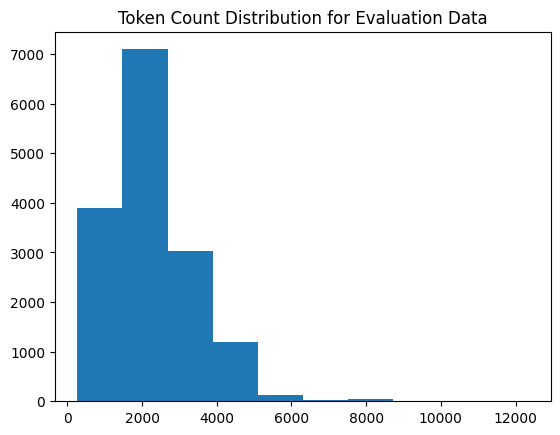

In [77]:
get_total_input_token_count_for_df(df, _template, enc).hist(grid=False)

plt.title("Token Count Distribution for Evaluation Data")
plt.show()

What I wanted to check above is that we're not overestimating due to truncation, but since all of the models' context should be 8192, we're on the safe side using these counts.

In [86]:
total_cost = {}

for model, ic in tqdm(input_cost.items()):
    try:
        _enc = get_encoder(model)
    except KeyError:
        print(f"Falling back to gpt-4o tokenizer for {model}")
        _enc = get_encoder("gpt-4o")
    counts = get_total_input_token_count_for_df(df, _template, _enc)
    total_cost[model] = counts.sum() * ic / 1e6 + counts.count() * 3 * output_cost[model] / 1e6  # number of tokens * cost per 1M token / 1M + number of outputs * cost per 1M output token * 3 / 1M



  0%|          | 0/5 [00:00<?, ?it/s]

Falling back to gpt-4o tokenizer for chatgpt-4o-latest


100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


In [90]:
print("Total cost for the faithfulness evaluation")
pd.Series(total_cost).apply(lambda x: f"${x:.2f}")

Total cost for the faithfulness evaluation


chatgpt-4o-latest          $166.48
gpt-4-turbo                $335.74
gpt-4-turbo-2024-04-09     $335.74
gpt-4                     $1005.84
gpt-4-32k                 $2011.69
dtype: object